In [2]:
%autosave 0

import sys
import random
import glob
import seaborn as sb
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# display plots in the notebook
%matplotlib inline
# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [3]:
sys.path.append("../")
from simulation.utils import bar_range, plot_ecdf
from simulation.data import percentage_of_groups_covered_with_varying_bitmaps

## Loading data

In [4]:
logs_dir = '/mnt/sdb1/baseerat/numerical-evals/logs-100K'

In [5]:
data = dict()

for i in bar_range(glob.glob(logs_dir + "/*/*.csv"), desc='loading'):
    _temp = i.split('/')
    file_name = _temp[-1]
    
    _temp_params = _temp[-2].split('.')
    cloud_params = _temp_params[0].split('_')
    optimizer_params = _temp_params[1].split('_')
    
    (seed, group_size_dist, placement_dist, num_colocate_hosts, num_bitmaps,
     num_leafs_per_bitmap, redundancy_per_bitmap, algoritm) = (
        int(cloud_params[-1]), cloud_params[9], cloud_params[10], int(cloud_params[11]), int(optimizer_params[2]), 
        int(optimizer_params[3]), int(optimizer_params[4]), optimizer_params[1])
   
    if placement_dist not in data:
        data[placement_dist] = dict()
    placement_dist_dict = data[placement_dist]

    if num_colocate_hosts not in placement_dist_dict:
        placement_dist_dict[num_colocate_hosts] = dict()
    num_colocate_hosts_dict =  placement_dist_dict[num_colocate_hosts] 
        
    if group_size_dist not in num_colocate_hosts_dict:
        num_colocate_hosts_dict[group_size_dist] = dict()
    group_size_dist_dict = num_colocate_hosts_dict[group_size_dist]

    if num_bitmaps not in group_size_dist_dict:
         group_size_dist_dict[num_bitmaps] = dict()
    num_bitmaps_dict = group_size_dist_dict[num_bitmaps]
    
    if num_leafs_per_bitmap == 0:
        num_leafs_per_bitmap = 1
    if num_leafs_per_bitmap not in num_bitmaps_dict:
        num_bitmaps_dict[num_leafs_per_bitmap] = dict()
    num_leafs_per_bitmap_dict = num_bitmaps_dict[num_leafs_per_bitmap]
    
    if redundancy_per_bitmap not in num_leafs_per_bitmap_dict:
        num_leafs_per_bitmap_dict[redundancy_per_bitmap] = dict()
    redundancy_per_bitmap_dict = num_leafs_per_bitmap_dict[redundancy_per_bitmap]
    
    if algoritm not in redundancy_per_bitmap_dict:
        redundancy_per_bitmap_dict[algoritm] = dict()
    algorithm_dict = redundancy_per_bitmap_dict[algoritm]
    
    try:
        algorithm_dict[file_name.split('.')[0]] = pd.Series.from_csv(i)
    except pd.io.common.EmptyDataError:
        algorithm_dict[file_name.split('.')[0]] = pd.Series()
        
simulation_setup = {'num_leafs': cloud_params[0], 
                    'num_hosts_per_leaf': cloud_params[1], 
                    'max_vms_per_host': cloud_params[2], 
                    'num_tenants': cloud_params[3], 
                    'min_vms_per_tenant': cloud_params[4],
                    'max_vms_per_tenant': cloud_params[5], 
                    'vm_dist': cloud_params[6], 
                    'num_groups': cloud_params[7], 
                    'num_rules_per_leaf': optimizer_params[-1]}
        
# data['colocate-random-linear'][24]['uniform'][10][1][0].keys()

loading: 100% |#################################################| Time: 0:02:50


## Simulation setup

In [5]:
simulation_setup

{'max_vms_per_host': '20',
 'max_vms_per_tenant': '5000',
 'min_vms_per_tenant': '10',
 'num_groups': '100000',
 'num_hosts_per_leaf': '48',
 'num_leafs': '576',
 'num_rules_per_leaf': '1000',
 'num_tenants': '3000',
 'vm_dist': 'expon'}

## Analysis

### 1. VM count for all tenants

In [6]:
vm_count_for_all_tenants = data['colocate-random-linear'][24]['uniform'][10][1][0]['single-match']['vm_count_for_all_tenants']
# Note: this is same across all runs.

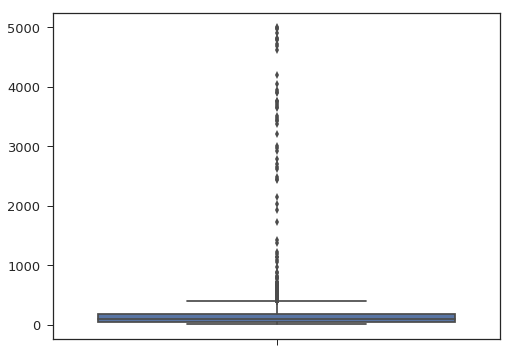

In [7]:
sb.set(style='ticks', font_scale=1.3)
sb.boxplot(y=vm_count_for_all_tenants)

In [8]:
sum(vm_count_for_all_tenants)

543464

In [9]:
vm_count_for_all_tenants.describe()

count    3000.000000
mean      181.154667
std       433.082649
min        10.000000
25%        46.000000
50%        98.000000
75%       184.000000
max      4999.000000
dtype: float64

### 2. Group count for all tenants

In [10]:
group_count_for_all_tenants = data['colocate-random-linear'][24]['uniform'][10][1][0]['single-match']['group_count_for_all_tenants']
# Note: this is same across all runs.

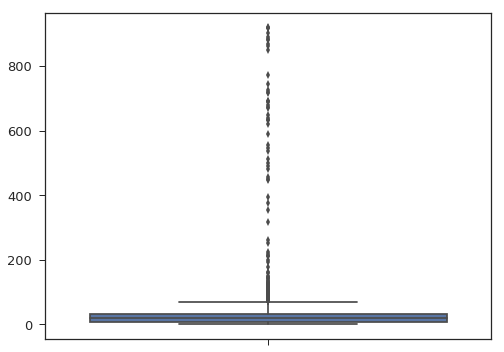

In [11]:
sb.set(style='ticks', font_scale=1.3)
sb.boxplot(y=group_count_for_all_tenants)

In [12]:
sum(group_count_for_all_tenants)

98512

In [13]:
group_count_for_all_tenants.describe()

count    3000.000000
mean       32.837333
std        79.683976
min         1.000000
25%         8.000000
50%        18.000000
75%        33.000000
max       919.000000
dtype: float64

### 3. Group sizes for all tenants

In [14]:
group_sizes_for_all_tenants_uniform = data['colocate-random-linear'][24]['uniform'][10][1][0]['single-match']['group_sizes_for_all_tenants']
group_sizes_for_all_tenants_wve = data['colocate-random-linear'][48]['wve'][10][1][0]['single-match']['group_sizes_for_all_tenants']

In [15]:
group_sizes_for_all_tenants = pd.DataFrame()

uniform_data = pd.DataFrame()
uniform_data['type'] = ['uniform' for _ in range(len(group_sizes_for_all_tenants_uniform))]
uniform_data['dist'] = group_sizes_for_all_tenants_uniform
group_sizes_for_all_tenants = group_sizes_for_all_tenants.append(uniform_data)

wve_data = pd.DataFrame()
wve_data['type'] = ['wve' for _ in range(len(group_sizes_for_all_tenants_wve))]
wve_data['dist'] = group_sizes_for_all_tenants_wve
group_sizes_for_all_tenants = group_sizes_for_all_tenants.append(wve_data)

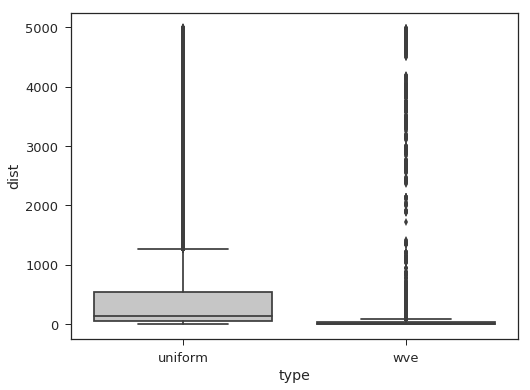

In [16]:
sb.set(style='ticks', font_scale=1.3)
sb.boxplot(x='type', y='dist', data=group_sizes_for_all_tenants, palette='Greys')

In [17]:
group_sizes_for_all_tenants_uniform.describe()

count    98512.000000
mean       615.837157
std       1012.131104
min          5.000000
25%         56.000000
50%        143.000000
75%        539.000000
max       4997.000000
dtype: float64

In [18]:
group_sizes_for_all_tenants_wve.describe()

count    98512.000000
mean        60.217730
std        282.936607
min          5.000000
25%          7.000000
50%         12.000000
75%         41.000000
max       4988.000000
dtype: float64

### 4. Leafs for all groups in all tenants

In [19]:
leafs_for_all_groups_in_all_tenants_uniform = dict()
leafs_for_all_groups_in_all_tenants_wve = dict()

for h in data['colocate-random-linear']:
    leafs_for_all_groups_in_all_tenants_uniform[h] = data['colocate-random-linear'][h]['uniform'][10][1][0]['single-match']['leafs_for_all_groups_in_all_tenants']
    leafs_for_all_groups_in_all_tenants_wve[h] = data['colocate-random-linear'][h]['wve'][10][1][0]['single-match']['leafs_for_all_groups_in_all_tenants']

In [20]:
leafs_for_all_groups_in_all_tenants = pd.DataFrame()

for h in data['colocate-random-linear']:
    uniform_data = pd.DataFrame()
    uniform_data['type'] = ['uniform' for _ in range(len(leafs_for_all_groups_in_all_tenants_uniform[h]))]
    uniform_data['hosts'] = [h for _ in range(len(leafs_for_all_groups_in_all_tenants_uniform[h]))]
    uniform_data['dist'] = leafs_for_all_groups_in_all_tenants_uniform[h]
    leafs_for_all_groups_in_all_tenants = leafs_for_all_groups_in_all_tenants.append(uniform_data)

    wve_data = pd.DataFrame()
    wve_data['type'] = ['wve' for _ in range(len(leafs_for_all_groups_in_all_tenants_wve[h]))]
    wve_data['hosts'] = [h for _ in range(len(leafs_for_all_groups_in_all_tenants_wve[h]))]
    wve_data['dist'] = leafs_for_all_groups_in_all_tenants_wve[h]
    leafs_for_all_groups_in_all_tenants = leafs_for_all_groups_in_all_tenants.append(wve_data)

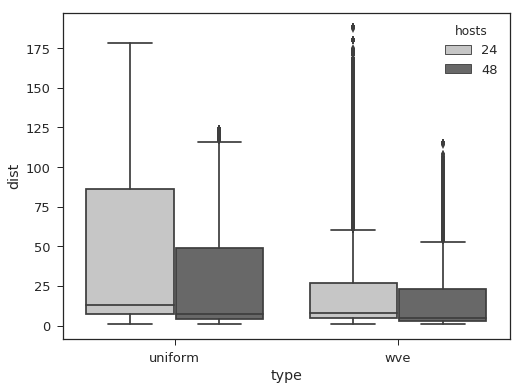

In [21]:
sb.set(style='ticks', font_scale=1.3)
sb.boxplot(x='type', y='dist', hue='hosts', data=leafs_for_all_groups_in_all_tenants, palette='Greys')

### 5. Rules for all leafs

In [22]:
def plot_rules_for_all_leafs(data, l, r, ax):
    _dict = dict()
    for b in data:
        if b not in _dict:
            _dict[b] = dict()
        for a in data[b][l][r]:
            _dict[b][a] = data[b][l][r][a]['rules_for_all_leafs']
                
    _df = pd.DataFrame()
    for b in _dict:
        for a in _dict[b]:
            _data = pd.DataFrame()
            _data['rules'] = _dict[b][a]
            _data['bitmaps'] = [b for _ in range(len(_dict[b][a]))]
            _data['algo'] = [a for _ in range(len(_dict[b][a]))]
            _df = _df.append(_data)
    
    sb.set(style='ticks', font_scale=1.3)
    sb.boxplot(x='bitmaps', y='rules', hue='algo', data=_df, palette='Greys', ax=ax)        

In [23]:
def plot_traffic_overhead(data, l, r, ax):
    _dict = dict()
    for b in data:
        if b not in _dict:
            _dict[b] = dict()
        for a in data[b][l][r]:
            _dict[b][a] = data[b][l][r][a]['traffic_overhead']
                
    _df = pd.DataFrame()
    for b in _dict:
        for a in _dict[b]:
            _data = pd.DataFrame()
            _data['traffic overhead(%)'] = _dict[b][a]
            _data['bitmaps'] = [b for _ in range(len(_dict[b][a]))]
            _data['algo'] = [a for _ in range(len(_dict[b][a]))]
            _df = _df.append(_data)
    
    sb.set(style='ticks', font_scale=1.3)
    g = sb.barplot(x='bitmaps', y='traffic overhead(%)', hue='algo', data=_df, palette='Greys', ax=ax)  
    g.set(ylim=(0, 100))

#### 5.1. With colocate-random-linear placement, 48 colocated hosts per leaf ...

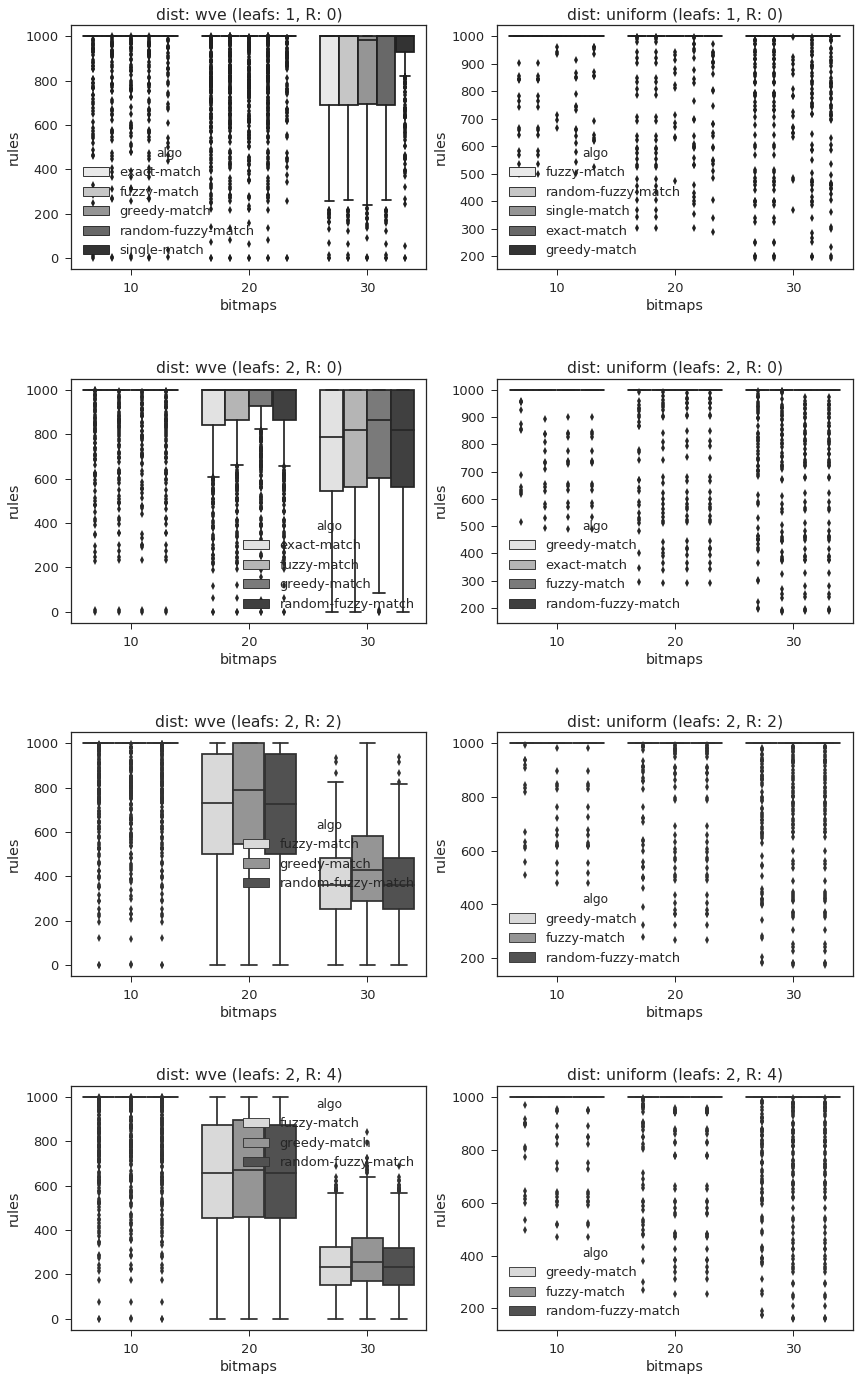

In [27]:
fig, axs = plt.subplots(nrows=6-2, ncols=2, figsize=(14, 4*6))
fig.subplots_adjust(hspace=.45)
i = 0
for r in [0, 2, 4]:
    for l in [1, 2]:
        if l == 1 and r > 0:
            continue
        plot_rules_for_all_leafs(data['colocate-random-linear'][48]['wve'], l, r, axs[i][0])
        axs[i][0].set_title('dist: %s (leafs: %s, R: %s)' % ('wve', l, r)) 
        plot_rules_for_all_leafs(data['colocate-random-linear'][48]['uniform'], l, r, axs[i][1])
        axs[i][1].set_title('dist: %s (leafs: %s, R: %s)' % ('uniform', l, r)) 
        i += 1
# fig.savefig('rules--placement-colocate-random-linear--colocate-hosts-48.pdf')

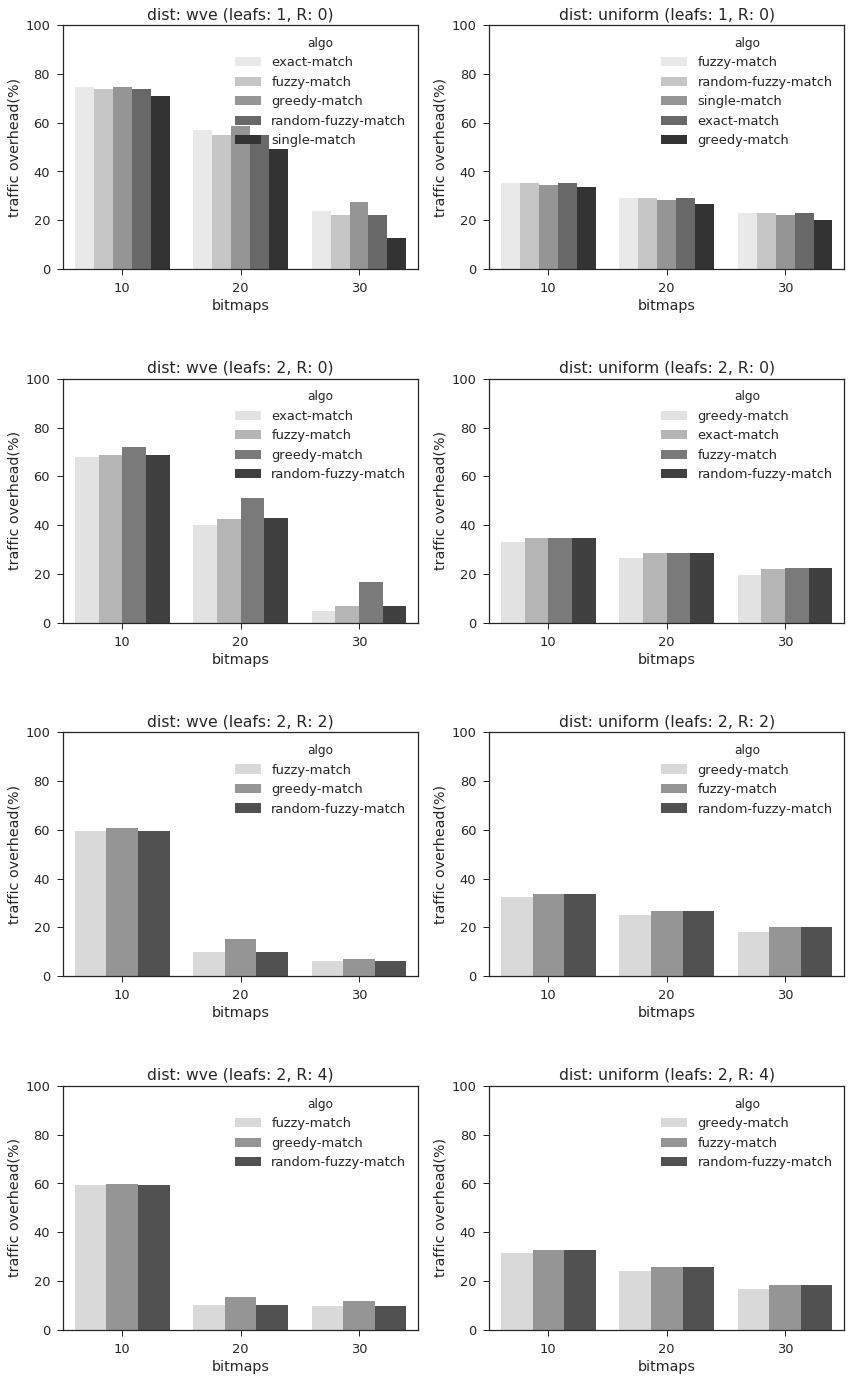

In [28]:
fig, axs = plt.subplots(nrows=6-2, ncols=2, figsize=(14, 4*6))
fig.subplots_adjust(hspace=.45)
i = 0
for r in [0, 2, 4]:
    for l in [1, 2]:
        if l == 1 and r > 0:
            continue
        plot_traffic_overhead(data['colocate-random-linear'][48]['wve'], l, r, axs[i][0])
        axs[i][0].set_title('dist: %s (leafs: %s, R: %s)' % ('wve', l, r)) 
        plot_traffic_overhead(data['colocate-random-linear'][48]['uniform'], l, r, axs[i][1])
        axs[i][1].set_title('dist: %s (leafs: %s, R: %s)' % ('uniform', l, r)) 
        i += 1
# fig.savefig('traffic-overhead--placement-colocate-random-linear--colocate-hosts-48.pdf')

#### 5.2. With colocate-random-linear placement, 24 colocated hosts per leaf ...

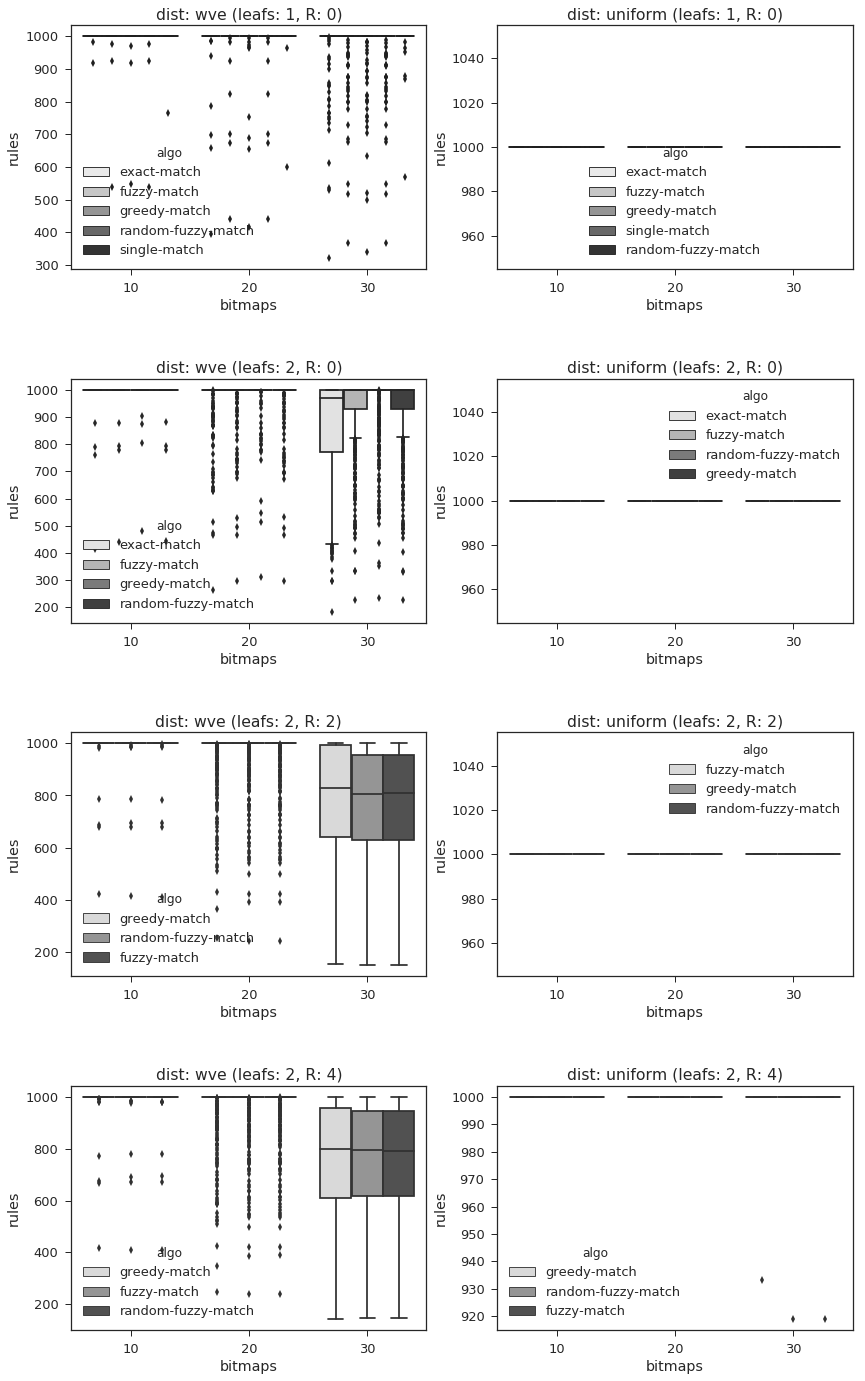

In [29]:
fig, axs = plt.subplots(nrows=6-2, ncols=2, figsize=(14, 4*6))
fig.subplots_adjust(hspace=.45)
i = 0
for r in [0, 2, 4]:
    for l in [1, 2]:
        if l == 1 and r > 0:
            continue
        plot_rules_for_all_leafs(data['colocate-random-linear'][24]['wve'], l, r, axs[i][0])
        axs[i][0].set_title('dist: %s (leafs: %s, R: %s)' % ('wve', l, r)) 
        plot_rules_for_all_leafs(data['colocate-random-linear'][24]['uniform'], l, r, axs[i][1])
        axs[i][1].set_title('dist: %s (leafs: %s, R: %s)' % ('uniform', l, r)) 
        i += 1
# fig.savefig('rules--placement-colocate-random-linear--colocate-hosts-24.pdf')

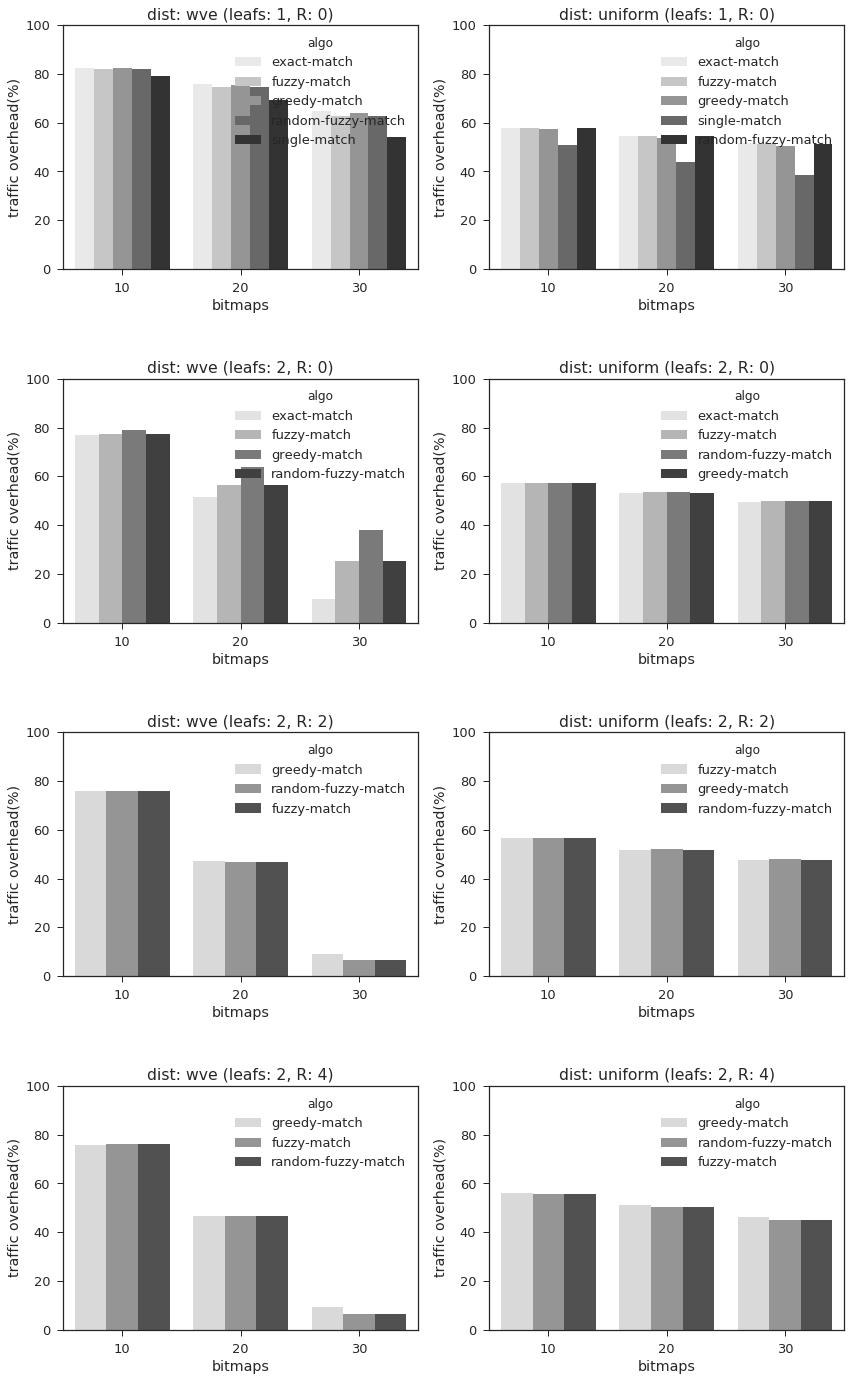

In [30]:
fig, axs = plt.subplots(nrows=6-2, ncols=2, figsize=(14, 4*6))
fig.subplots_adjust(hspace=.45)
i = 0
for r in [0, 2, 4]:
    for l in [1, 2]:
        if l == 1 and r > 0:
            continue
        plot_traffic_overhead(data['colocate-random-linear'][24]['wve'], l, r, axs[i][0])
        axs[i][0].set_title('dist: %s (leafs: %s, R: %s)' % ('wve', l, r)) 
        plot_traffic_overhead(data['colocate-random-linear'][24]['uniform'], l, r, axs[i][1])
        axs[i][1].set_title('dist: %s (leafs: %s, R: %s)' % ('uniform', l, r)) 
        i += 1
# fig.savefig('traffic-overhead--placement-colocate-random-linear--colocate-hosts-24.pdf')